<a href="https://colab.research.google.com/github/ELehmann91/FS1/blob/master/Sentiment_IMDB_TFIDF_LSTM_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment classification - close to the state of the art

The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured.

For this assignment you have to use the larger [IMDB sentiment](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) benchmark dataset from Stanford, an achieve close to state of the art results.

The task is to try out multiple models in ascending complexity, namely:

1. TFIDF + classical statistical model (eg. RandomForest)
2. LSTM classification model
3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors
4. fastText model
5. BERT based model (you are advised to use a pre-trained one and finetune, since the resource consumption is considerable!)

You should get over 90% validation accuracy (though nearly 94 is achievable).

You are allowed to use any library or tool, though the Keras environment, and some wrappers on top (ie. Ktrain) make your life easier.





__Groups__
This assignment is to be completed individually, two weeks after the class has finished. For the precise deadline please see canvas.

__Format of submission__
You need to submit a pdf of your Google Collab notebooks.

__Due date__
Two weeks after the class has finished. For the precise deadline please see canvas.

Grade distribution:
1. TFIDF + classical statistical model (eg. RandomForest) (25% of the final grade)
2. LSTM classification model (15% of the final grade)
3. LSTM model, where the embeddings are initialized with pre-trained GloVe vectors (15% of the final grade)
4. fastText model (15% of the final grade)
5. BERT based model (you are advised to use a pre-trained one and finetune it, since the resource consumption is considerable!) (30% of the final grade). For BERT you should get over 90% validation accuracy (though nearly 94% is achievable).


__For each of the models, the marks will be awarded according to the following three criteria__:

(1) The (appropriately measured) accuracy of your prediction for the task. The more accurate the prediction is, the better. Note that you need to validate the predictive accuracy of your model on a hold-out of unseen data that the model has not been trained with.

(2) How well you motivate the use of the model - what in this model's structure makes it suited for representing sentiment? After using the model for the task how well you evaluate the accuracy you got for each model and discuss the main advantages and disadvantages the model has in the particular modelling task. At best you take part of the modelling to support your arguments.

(3) The consistency of your take-aways, i.e. what you have learned from your analyses. Also, analyze when the model is good and when and where it does not predict well.

Please make sure that you comment with # on the separates steps of the code you have produced. For the verbal description and analyses plesae insert markdown cells.


__Plagiarism__: The Frankfurt School does not accept any plagiarism. Data science is a collaborative exercise and you can discuss the research question with your classmates from other groups, if you like. You must not copy any code or text though. Plagiarism will be prosecuted and will result in a mark of 0 and you failing this class.

After carefully reading this document and having had a look at the data you may still have questions. Please submit those question to the public Q&A board in canvas and we will answer each question, so 

# Imports

## Attention Layer

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 15 19:20:18 2018

@author: himanshu
"""

import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import sys

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints
from sklearn.metrics import roc_auc_score

class Attention(Layer):
     # Input shape 3D tensor with shape: `(samples, steps, features)`.
     # Output shape 2D tensor with shape: `(samples, features)`.

    def __init__(self, step_dim,W_regulizer = None,b_regulizer = None,
                 W_constraint = None, b_constraint = None,bias = True,**kwargs):
        
        self.W_regulizer = W_regulizer
        self.b_regulizer = b_regulizer
        
        self.W_constraint = W_constraint
        self.b_constraint = b_constraint
        
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        self.init = initializers.get('glorot_uniform')
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='kernel', 
                                      shape=(input_shape[-1],),
                                      initializer= self.init,
                                      constraint = self.W_constraint,
                                      regularizer = self.W_regulizer)#,
                                      #name = '{}_W'.format(self.name))
        
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regulizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        super(Attention, self).build(input_shape)  

    
    def call(self, x, mask=None):
      
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
           
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
  
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Download Data

In [245]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2019-12-20 15:38:52--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.2’

aclImdb_v1.tar.gz.2 100%[===================>]  80.23M  60.2MB/s    in 1.3s    

2019-12-20 15:38:54 (60.2 MB/s) - ‘aclImdb_v1.tar.gz.2’ saved [84125825/84125825]

aclImdb		     aclImdb_v1.tar.gz.2  glove.6B.300d.txt  sample_data
aclImdb_v1.tar.gz    glove.6B.100d.txt	  glove.6B.50d.txt
aclImdb_v1.tar.gz.1  glove.6B.200d.txt	  glove.6B.zip


In [10]:
!ls aclImdb  

imdbEr.txt  imdb.vocab	README	test  train


In [11]:
!cat aclImdb/README  

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

## Load Data

In [0]:
import os
import numpy as np
import random

def load_imdb_sentiment_analysis_dataset():
    seed=123
    imdb_data_path = 'aclImdb'

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)
              
    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    random.seed(seed)
    random.shuffle(test_texts)
    random.seed(seed)
    random.shuffle(test_labels)
    train_texts.extend(test_texts)
    train_labels.extend(test_labels)

    return train_texts, np.array(train_labels)

In [0]:
texts, labels = load_imdb_sentiment_analysis_dataset()

In [14]:
print(len(texts),len(labels))

50000 50000


# Text Preprocessing

In [15]:
import re
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# dictionary for resolving contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [0]:
sw = [w for w in sw if w not  in ['no','not','nor']]

In [0]:
# I tried different prerocessing steps and got best results for those steps
def prepro(train):
    train = [' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in sen.split()]) for sen in train] 
    #train = [' '.join([lemmatizer.lemmatize(word) for word in sen.split()]) for sen in train]
    #train = [' '.join([word for word in sen.split() if word not in sw]) for sen in train]
    train = [sen.replace('/n',' ') for sen in train]
    #train = [sen.replace('-',' ') for sen in train]
    train = [sen.replace('<br />',' ') for sen in train]
    #train = [sen.replace('.',' <Punkt>') for sen in train]
    #train = [sen.replace(',',' <Comma>') for sen in train]
    #train = [sen.replace('?',' <questionmark>') for sen in train]
    #train = [sen.replace('!',' <exclamationmark>') for sen in train]
    train = [sen.lower() for sen in train]
    train = [re.sub("[^A-Za-z1-9]+", ' ',sen) for sen in train]
    train = [' '.join([word for word in sen.split() if len(word)>1]) for sen in train]
    
    return train

In [19]:
texts[8:10]

["Director Douglas Sirk once said `there's a very short distance between high art and trash, and trash that contains craziness is by this very quality nearer to art'. This statement defines his cinema perfectly, a very unique body of work that includes classic stage adaptations, adventure and war films, westerns and of course, his famous melodramas.<br /><br />Sirk's melodramas were, as the very word signifies, dramas with music. The music sets the tone for his masterful style, and every stroke of his brush (Sirk was also a painter) leaves a powerful image on the screen-turned-canvas. But this ain't life but its representation, an imitation of life. Sirk never tried to show reality, on the contrary. None of the directors of his generation made a better use of all the technical devices provided by Hollywood (most notably Technicolor) to distinguish the artificial from the real thing. Let's remember that his golden period coincides with the time when Hollywood films turned its attention 

In [0]:
texts_prepro = prepro(texts)
#X_train, X_test, y_train, y_test = train_test_split(texts_prepro, labels, test_size=0.2, random_state = 166)

In [21]:
texts_prepro[8:10]

['director douglas sirk once said there very short distance between high art and trash and trash that contains craziness is by this very quality nearer to art this statement defines his cinema perfectly very unique body of work that includes classic stage adaptations adventure and war films westerns and of course his famous melodramas sirk melodramas were as the very word signifies dramas with music the music sets the tone for his masterful style and every stroke of his brush sirk was also painter leaves powerful image on the screen turned canvas but this is not life but its representation an imitation of life sirk never tried to show reality on the contrary none of the directors of his generation made better use of all the technical devices provided by hollywood most notably technicolor to distinguish the artificial from the real thing let remember that his golden period coincides with the time when hollywood films turned its attention into the social drama blackboard jungle rebel wit

In [0]:
#split the data in train and test as given + splitting a holdout from test  
X_train = texts_prepro[:25000]
y_train = labels[:25000] 
X_test = texts_prepro[25000:40000]
y_test = labels[25000:40000]
X_holdout = texts_prepro[40000:]
y_holdout = labels[40000:]

In [23]:
print('Train: ',len(X_train),len(y_train))
print('Valid: ',len(X_test),len(y_test))
print('Test: ',len(X_holdout),len(y_holdout))

Train:  25000 25000
Valid:  15000 15000
Test:  10000 10000


## Shuffle texts for additional training data

In [0]:
from nltk.tokenize import sent_tokenize
import random

def shuffle_text(text):
    sents = sent_tokenize(text)
    newsents = sents[:]
    random.shuffle(newsents)
    newsents_str = ' '.join([sen for sen in newsents]) 
    return newsents_str


In [25]:
shuffle_text('I was blue. It is red. You are yellow. Are you sure?')

'I was blue. Are you sure? You are yellow. It is red.'

In [0]:
# if max sequence length cuts some sentences, why not shuffle the data to get more train data
add_text = [shuffle_text(doc) for doc in texts[:25000]]
add_label = labels[:25000] 
add_text_prepro = prepro(add_text)

In [0]:
X_train.extend(add_text_prepro)
y_train = np.append(y_train,add_label)

In [28]:
print('Train: ',len(X_train),len(y_train))
print('Valid: ',len(X_test),len(y_test))
print('Test: ',len(X_holdout),len(y_holdout))

Train:  50000 50000
Valid:  15000 15000
Test:  10000 10000


# Model

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
def final_score(model_pred,keras_model=True):
  '''
  calculates the scores for hold out test set
  '''
  if keras_model:
      y_pred_enc__ = model_pred.predict(X_ho_pad)
      y_pred__ = [np.argmax(y) for y in y_pred_enc__]
      print('accuracy hold out: %s' % accuracy_score(y_pred__, y_holdout))
  else:
      y_pred = model_pred.predict(X_train)
      y_pred_ = model_pred.predict(X_test)
      y_pred__ = model_pred.predict(X_holdout)
      print('accuracy %s' % accuracy_score(y_pred, y_train))
      print('accuracy %s' % accuracy_score(y_pred_, y_test))
  

In [0]:
# plots training process
import matplotlib.pyplot as plt
def plot_training(model_hist):
  # summarize history for accuracy
  plt.plot(model_hist.history['acc'])
  plt.plot(model_hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [172]:
# build test sentences to see where a model works
#for long sentences
long = []
long_ = []
long_score = []
for i in range(0,len(texts_prepro)):
    if len(texts_prepro[i].split()) > 600:
      long.append(texts_prepro[i])
      long_.append(texts[i])
      long_score.append(labels[i])
    if len(long)==100:
      break
#for short sentences
short = []
short_ = []
short_score = []
for i in range(0,len(texts_prepro)):
    if len(texts_prepro[i].split()) < 30:
      short.append(texts_prepro[i])
      short_.append(texts[i])
      short_score.append(labels[i])
    if len(short)==100:
      break
#medium sentences
med = []
med_ = []
med_score = []
for i in range(0,len(texts_prepro)):
    if 160 <len(texts_prepro[i].split()) < 170:
      med.append(texts_prepro[i])
      med_.append(texts[i])
      med_score.append(labels[i])
    if len(med)==100:
      break
# sentences with negation
neg = []
neg_ = []
neg_score = []
for i in range(0,len(texts_prepro)):
    if texts_prepro[i].count('not')>4:
      neg.append(texts_prepro[i])
      neg_.append(texts[i])
      neg_score.append(labels[i])
    if len(neg)==100:
      break

test_sentences = long + short + med + neg 
test_sentences_score = long_score + short_score + med_score + neg_score
print(len(test_sentences),len(test_sentences_score))

400 400


In [0]:
def test_sentences_fct(model_pred,max_length=269,keras_model=True):
  '''
  calculates the scores for the special test sentences
  '''
  if keras_model:
      y_pred_enc__ = model_pred.predict(text2num(long,max_length))
      y_pred__ = [np.argmax(y) for y in y_pred_enc__]
      print('long accuracy: %s' % accuracy_score(y_pred__, long_score))
      y_pred_enc__ = model_pred.predict(text2num(short,max_length))
      y_pred__ = [np.argmax(y) for y in y_pred_enc__]
      print('short accuracy: %s' % accuracy_score(y_pred__, short_score))
      y_pred_enc__ = model_pred.predict(text2num(med,max_length))
      y_pred__ = [np.argmax(y) for y in y_pred_enc__]
      print('med accuracy: %s' % accuracy_score(y_pred__, med_score))
      y_pred_enc__ = model_pred.predict(text2num(neg,max_length))
      y_pred__ = [np.argmax(y) for y in y_pred_enc__]
      print('neg accuracy: %s' % accuracy_score(y_pred__, neg_score))
  else:
      y_pred = model_pred.predict(long)
      print('long accuracy %s' % accuracy_score(y_pred, long_score))
      y_pred = model_pred.predict(short)
      print('short accuracy %s' % accuracy_score(y_pred, short_score))
      y_pred = model_pred.predict(med)
      print('medium accuracy %s' % accuracy_score(y_pred, med_score))
      y_pred = model_pred.predict(neg)
      print('negation accuracy %s' % accuracy_score(y_pred, neg_score))

  

## TF-IDF

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', CountVectorizer(max_features=2000)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression( C=1e7)),
               ])
logreg.fit(X_train, y_train)

final_score(logreg,False)

accuracy 0.90948
accuracy 0.8687333333333334


In [173]:
test_sentences_fct(logreg,False)

long accuracy 0.9
short accuracy 0.82
medium accuracy 0.93
negation accuracy 0.93


Close to 87% is a very good baseline for such a simple model (logistic regression with TF IDF weights). It seems to have problems with very short and very long sentences. This Model is very easy to reproduce and set productive. Not much knowledge and calculation power required. There are not much hyperparameter, restricting the number of features to 2000 worked best for me.


## LSTM

In [142]:
print('50%',np.quantile([len(s.split()) for s in texts_prepro],.50)) #2470
print('75%',np.quantile([len(s.split()) for s in texts_prepro],.75)) #2470
print('99%',np.quantile([len(s.split()) for s in texts_prepro],.95)) #2470

50% 166.0
75% 269.0
99% 571.0


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#max_features = 5000
tokenizer_ = Tokenizer()
tokenizer_.fit_on_texts(texts_prepro)

max_length = 269
vocab_size = len(tokenizer_.word_index) + 1

def text2num(text,max_length = 269):
    text_tok = tokenizer_.texts_to_sequences(text)
    text_pad = pad_sequences(text_tok,maxlen=max_length, padding='post')
    return text_pad

X_train_pad = text2num(X_train)
X_test_pad = text2num(X_test)
X_ho_pad = text2num(X_holdout)


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(labels)

def encode_label(y_):
  y__ = encoder.transform(y_)
  y_enc = np_utils.to_categorical(y__)
  return y_enc

y_train_enc = encode_label(y_train)
y_test_enc = encode_label(y_test)
y_ho_enc = encode_label(y_holdout)


In [145]:
print(y_train.shape, sum(y_train),y_test.shape, sum(y_test),y_holdout.shape, sum(y_holdout))

(50000,) 25000 (15000,) 7456 (10000,) 5044


In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, GRU, GlobalMaxPool1D,Bidirectional,Concatenate
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam,Adadelta,Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1_l2

### Plain Vanilla

In [147]:
embedding_dim = 64
dropout_rate =.8

input_imbd_1 = Input(shape = (max_length,), dtype = 'int32')
embedd_seq_1 = Embedding(vocab_size, embedding_dim, input_length = max_length, trainable = True,mask_zero=True)(input_imbd_1)
lstm_layer_1 = Bidirectional(LSTM(32, dropout = dropout_rate, return_sequences = False ))(embedd_seq_1)
pred_layer_1 = Dense(2, activation = 'softmax', kernel_regularizer=l1_l2(0.01))(lstm_layer_1)

lr= .0001
opt = Adam(lr=lr, decay=lr/50)

model = Model(inputs = [input_imbd_1], outputs = pred_layer_1)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
early_stopping = EarlyStopping(patience = 3)
hist = model.fit(x = X_train_pad, y = y_train_enc,\
                 validation_data = (X_test_pad, y_test_enc), \
                 epochs = 50, batch_size = 2048, shuffle = False, \
                 callbacks = [early_stopping])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 269)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 269, 64)           6446272   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 6,471,234
Trainable params: 6,471,234
Non-trainable params: 0
_________________________________________________________________
None
Train on 50000 samples, validate on 15000 samples
Epoch 1/50
50000/50000 [==============================] - 43s 861us/step - loss: 0.9333 - acc: 0.5040 - val_loss: 0.9305 - val_acc: 0.5327
Epoch 2/50
50000/50000 [=============================

accuracy 0.8756
None


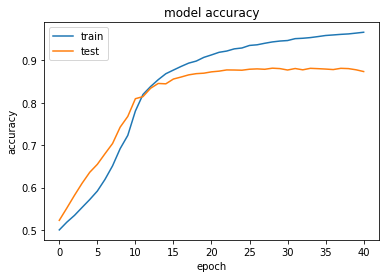

In [0]:
print(final_score(model,True))
plot_training(hist)

In [174]:
test_sentences_fct(model,True)

long accuracy: 0.98
short accuracy: 0.87
med accuracy: 0.98
neg accuracy: 1.0


The basic LSTM performs (only) slightly (.7%) better then the logistic regression. In the test cases it performs much better, largest improvements in long sentences and negation. Thats what I would have expected, because LSTM can store information from previous tokens and therfore store information over longer documents and detect negations. The downside is, preprocessing and training took longer and it is still overfitting. 

That was the Baseline LSTM, now I want to try to add Attention, pretrained Embeddings and more layers to improve accuracy.

### Attention


In [201]:
embedding_dim = 100
dropout_rate =.25

input_imbd_1 = Input(shape = (max_length,), dtype = 'int32')
embedd_seq_1 = Embedding(vocab_size, embedding_dim, input_length = max_length, trainable = True)(input_imbd_1)
lstm_layer_1 = Bidirectional(LSTM(32, dropout = dropout_rate, return_sequences = True ))(embedd_seq_1)
attention_1 = Attention(max_length)(lstm_layer_1)
pred_layer_1 = Dense(2, activation = 'softmax', kernel_regularizer=l1_l2(0.001))(attention_1)

lr = .0001
opt = Adam(lr=lr, decay=lr/50)
model = Model(inputs = [input_imbd_1], outputs = pred_layer_1)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
early_stopping = EarlyStopping(patience = 3)
hist = model.fit(x = X_train_pad, y = y_train_enc,\
                 validation_data = (X_test_pad, y_test_enc), \
                 epochs = 50, batch_size = 2048, shuffle = True, \
                 callbacks = [early_stopping])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 269)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 269, 100)          10072300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 269, 64)           34048     
_________________________________________________________________
attention_2 (Attention)      (None, 64)                333       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 10,106,811
Trainable params: 10,106,811
Non-trainable params: 0
_________________________________________________________________
None
Train on 50000 samples, validate on 15000 samples
Epoch 1/50
50000/50000 [==============================] - 

accuracy hold out: 0.8724
None


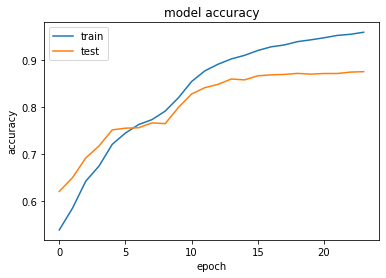

In [202]:
print(final_score(model,True))
plot_training(hist)

### Glove Embeddings & Attention

In [0]:
%%capture
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [37]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [38]:
!ls

aclImdb		     glove.6B.100d.txt	glove.6B.50d.txt
aclImdb_v1.tar.gz    glove.6B.200d.txt	glove.6B.zip
aclImdb_v1.tar.gz.1  glove.6B.300d.txt	sample_data


In [39]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [0]:
#vocab_to_emb = utils.load_embed_dict('vocab_to_emb_w2v_300.p')
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word,i in tokenizer_.word_index.items():
    try:
        embedding_matrix[i] = embeddings_index[word]
    except KeyError:
        pass
        #embedding_matrix[i] = np.random.rand(embedding_dim)

In [0]:
embedding_matrix.shape

(100723, 100)

In [0]:
dropout_rate=.3

input_imbd_2 = Input(shape = (max_length,), dtype = 'int32')
embedd_seq_2 = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False)(input_imbd_2)
lstm_layer_2 = Bidirectional(LSTM(32, dropout = dropout_rate, return_sequences = True ))(embedd_seq_2)
attention_2 = Attention(max_length)(lstm_layer_2)
pred_layer_2 = Dense(2, activation = 'softmax', kernel_regularizer=l1_l2(0.0001))(attention_2)

model_1 = Model(inputs = [input_imbd_2], outputs = pred_layer_2)

lr = .005
opt = Adam(lr=lr, decay=lr/50)

model_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model_1.summary())

early_stopping = EarlyStopping(patience = 3)

hist = model_1.fit(x = X_train_pad, y = y_train_enc,\
                 validation_data = (X_test_pad, y_test_enc), \
                 epochs = 50, batch_size = 2048, shuffle = False, \
                 callbacks = [early_stopping])
best_score = min(hist.history['val_loss'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 269)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 269, 100)          10072300  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 269, 64)           34048     
_________________________________________________________________
attention_1 (Attention)      (None, 64)                333       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 10,106,811
Trainable params: 34,511
Non-trainable params: 10,072,300
_______________________________________________

accuracy 0.8841
None


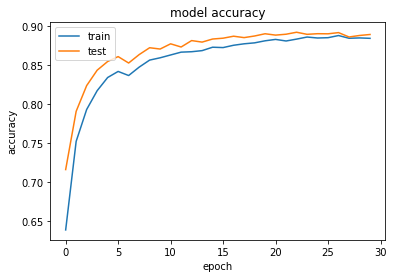

In [0]:
print(final_score(model_1,True))
plot_training(hist)

### Multilayer LSTM Embeddings & Attention

In [0]:
dropout_rate=.25

input_imbd_2 = Input(shape = (max_length,), dtype = 'int32')
embedd_seq_2 = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False)(input_imbd_2)
lstm_layer_2 = Bidirectional(LSTM(32, dropout = dropout_rate,  return_sequences = True ))(embedd_seq_2)
lstm_layer_2_2 = Bidirectional(LSTM(16, dropout = dropout_rate,  return_sequences = True ))(lstm_layer_2)
attention_2 = Attention(max_length)(lstm_layer_2)
attention_2_2 = Attention(max_length)(lstm_layer_2_2)
added_2 = Concatenate(axis=-1)([attention_2, attention_2_2])
dens_layer_2 = Dense(32)(added_2)
pred_layer_2 = Dense(2, activation = 'softmax', kernel_regularizer=l1_l2(0.001))(dens_layer_2)

model_1 = Model(inputs = [input_imbd_2], outputs = pred_layer_2)

lr = .01
opt = Adam(lr=lr, decay=lr/100)

model_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model_1.summary())

early_stopping = EarlyStopping(patience = 3)

hist = model_1.fit(x = X_train_pad, y = y_train_enc,\
                 validation_data = (X_test_pad, y_test_enc), \
                 epochs = 50, batch_size = 2048, shuffle = True, \
                 callbacks = [early_stopping])
best_score = min(hist.history['val_loss'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 269)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 269, 100)     10072300    input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 269, 64)      34048       embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 269, 32)      10368       bidirectional_8[0][0]            
____________________________________________________________________________________________

accuracy 0.8976
None


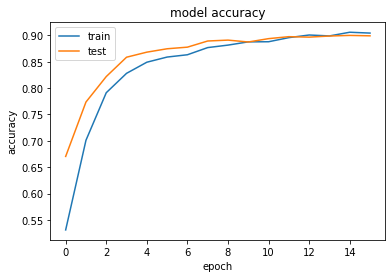

In [0]:
print(final_score(model_1,True))
plot_training(hist)

### Multilayer LSTM with Increases Sequence Length

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#max_features = 5000
tokenizer_ = Tokenizer()
tokenizer_.fit_on_texts(texts_prepro)

max_length = 571
vocab_size = len(tokenizer_.word_index) + 1

X_train_tokens = tokenizer_.texts_to_sequences(X_train)
X_test_tokens = tokenizer_.texts_to_sequences(X_test)
X_ho_tokens = tokenizer_.texts_to_sequences(X_holdout)

X_train_pad = pad_sequences(X_train_tokens,maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens,maxlen=max_length, padding='post')
X_ho_pad = pad_sequences(X_ho_tokens,maxlen=max_length, padding='post')

In [47]:
dropout_rate=.25

input_imbd_2 = Input(shape = (max_length,), dtype = 'int32')
embedd_seq_2 = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False)(input_imbd_2)
lstm_layer_2 = Bidirectional(LSTM(32, dropout = dropout_rate,  return_sequences = True ))(embedd_seq_2)
lstm_layer_2_2 = Bidirectional(LSTM(16, dropout = dropout_rate,  return_sequences = True ))(lstm_layer_2)
attention_2 = Attention(max_length)(lstm_layer_2)
attention_2_2 = Attention(max_length)(lstm_layer_2_2)
added_2 = Concatenate(axis=-1)([attention_2, attention_2_2])
dens_layer_2 = Dense(32)(added_2)
pred_layer_2 = Dense(2, activation = 'softmax', kernel_regularizer=l1_l2(0.001))(dens_layer_2)

model_1 = Model(inputs = [input_imbd_2], outputs = pred_layer_2)

lr = .01
opt = Adam(lr=lr, decay=lr/100)

model_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model_1.summary())

early_stopping = EarlyStopping(patience = 3)

hist = model_1.fit(x = X_train_pad, y = y_train_enc,\
                 validation_data = (X_test_pad, y_test_enc), \
                 epochs = 50, batch_size = 2048, shuffle = True, \
                 callbacks = [early_stopping])


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 571)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 571, 100)     10072300    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 571, 64)      34048       embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 571, 32)      10368       bidirectional_3[0][0]            
____________________________________________________________________________________________

accuracy hold out: 0.9019
None


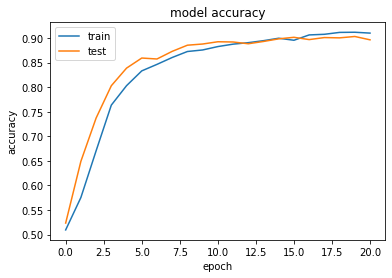

In [54]:
print(final_score(model_1,True))
plot_training(hist)

90% Accuracy! woohoo

In [177]:
test_sentences_fct(model_1,571,True)

long accuracy: 0.96
short accuracy: 0.91
med accuracy: 0.89
neg accuracy: 0.99


With increasing complexity model got better and reached 90% on the hold out set. It performed quite well on long sentences and negation (Attention should help here), improved much on short sentences (pre trained embedding put it in a certain context), but lost on the medium length sentences?

Increasing the accurracy to 90% took some time, training, trying architectures and CPU power. If its worth it depends on the problem, here we get a sentiment classifier which could be used for other task. For other problems logistic regression will still be enaugth or 90% accuracy even to less. 

In [0]:
#learner = ktrain.get_learner(model_1, 
#                             train_data=(X_train_pad, y_train_enc), 
#                             val_data=(X_test_pad, y_test_enc), 
#                             batch_size=512)

### Fasttext Embeddings

In [246]:
def split_in_words(text):
  return [([w for w in doc.split()]) for doc in text]
split_in_words(['I am cool. And you not','second sentence'])

[['I', 'am', 'cool.', 'And', 'you', 'not'], ['second', 'sentence']]

In [0]:
from gensim.models import FastText
text_split = split_in_words(texts_prepro)
model_ted = FastText(size=100, window=7, workers=4,sg=1)
model_ted.build_vocab(sentences=text_split)
model_ted.train(sentences=text_split, total_examples=len(text_split), epochs=10)  # train

In [0]:
embedding_dim=100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word,i in tokenizer_.word_index.items():
    try:
        embedding_matrix[i] = model_ted.wv[word]
    except KeyError:
        embedding_matrix[i] = np.random.rand(embedding_dim)

In [198]:
keras.backend.clear_session()

dropout_rate=.25

input_imbd_2 = Input(shape = (max_length,), dtype = 'int32')
embedd_seq_2 = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = True)(input_imbd_2)
lstm_layer_2 = Bidirectional(LSTM(16, dropout = dropout_rate, recurrent_dropout = dropout_rate, return_sequences = True ))(embedd_seq_2)
attention_2 = Attention(max_length)(lstm_layer_2)
pred_layer_2 = Dense(2, activation = 'softmax', kernel_regularizer=l1_l2(0.001))(attention_2)

model = Model(inputs = [input_imbd_2], outputs = pred_layer_2)

lr = .001
opt = Adam(lr=lr, decay=lr/100)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

early_stopping = EarlyStopping(patience = 4)

hist = model.fit(x = X_train_pad, y = y_train_enc,\
                 validation_data = (X_test_pad, y_test_enc), \
                 epochs = 50, batch_size = 2096, shuffle = True, \
                 callbacks = [early_stopping])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 269)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 269, 100)          10072300  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 269, 32)           14976     
_________________________________________________________________
attention_1 (Attention)      (None, 32)                301       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 10,087,643
Trainable params: 10,087,643
Non-trainable params: 0
_________________________________________________________________
None
Train on 50000 samples, validate on 15000 samples
Epoch 1/50
50000/50000 [==============================] - 

accuracy hold out: 0.8755
None


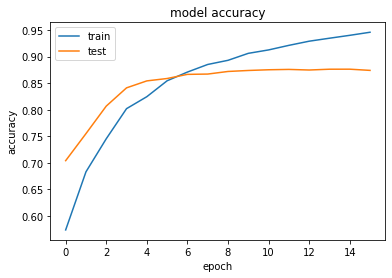

In [199]:
print(final_score(model,True))
plot_training(hist)

In [200]:
test_sentences_fct(model,269,True)

long accuracy: 0.95
short accuracy: 0.85
med accuracy: 0.97
neg accuracy: 0.97


Fasttext normaly has its strength in short and dirty texts, because it can produce vectors for out of vocabulary words due to trained n-grams. I therefore would use it to analyse twitter or social media data in general where misspellings are commen and abreviations are used. In this case the model is not pretrained, that should explain the performance on short sentences. 

## BERT

In [0]:
%%capture
!pip install ktrain
import ktrain
from ktrain import text as txt

In [276]:
(x_train, y_train), (x_test, y_test), preproc = txt.texts_from_folder('aclImdb', maxlen=500, 
                                                                     preprocess_mode='bert',
                                                                     train_test_names=['train', 'test'],
                                                                     classes=['pos', 'neg'])
print(len(x_train), len(y_train),len(x_test), len(y_test))

detected encoding: utf-8
preprocessing train...
language: en


preprocessing test...
language: en


2 25000 2 25000


In [0]:
x_holdout = []
x_holdout.append(x_test[0][15000:])
x_holdout.append(x_test[1][15000:])
y_holdout = y_test[15000:]

x_test_ = []
x_test_.append(x_test[0][:15000])
x_test_.append(x_test[1][:15000])
y_test_ = y_test[:15000]

In [278]:
# load model
model = txt.text_classifier('bert', (x_train, y_train), preproc=preproc)

 
# wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test_, y_test_), 
                             batch_size=2)

Is Multi-Label? False
maxlen is 500
done.


In [0]:
#learner.lr_find()             # briefly simulate training to find good learning rate
#learner.lr_plot()             # visually identify best learning rate

In [272]:
print(len(x_train[0]), len(y_train),len(x_test[0]), len(y_test))

25000 25000 25000 15000


In [0]:
# using 1cycle learning rate schedule for 3 epochs
learner.fit_onecycle(2e-5, 2) 



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 15000 samples
Epoch 1/2
25000/25000 [==============================] - 2742s 110ms/sample - loss: 0.2588 - acc: 0.8925 - val_loss: 0.4824 - val_acc: 0.8315
Epoch 2/2
 4488/25000 [====>.........................] - ETA: 31:43 - loss: 0.1732 - acc: 0.9329

In [7]:
# using 1cycle learning rate schedule for 3 epochs
learner.fit_onecycle(2e-5, 3) 



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 2924s 117ms/sample - loss: 0.2530 - acc: 0.8954 - val_loss: 0.1865 - val_acc: 0.9309
Epoch 2/3
25000/25000 [==============================] - 2925s 117ms/sample - loss: 0.1678 - acc: 0.9382 - val_loss: 0.1994 - val_acc: 0.9311
Epoch 3/3
25000/25000 [==============================] - 2923s 117ms/sample - loss: 0.0613 - acc: 0.9804 - val_loss: 0.1892 - val_acc: 0.9416


In [0]:
model._make_predict_function()
predictor = ktrain.get_predictor(learner.model, preproc)

In [0]:
pred = predictor.predict(texts[40000:])

In [0]:
y_pred = [ int(np.where(x=='neg',1,0)) for x in pred]

In [286]:
y_hold = [np.argmax(y) for y in y_holdout]
print('holdout accuracy %s' % accuracy_score(y_pred, y_hold))

long accuracy 0.9843


Bert delivers by far the best results,it's almost frightening how easy one can reach state of the art results with just a template. The downside from using this template is, that it isn't easily customizable, it is even hard to get a hold out accuracy. Furthermore it takes a lot of ressources and is very slow and probably not easy to set to production. This should only be used if realy needed.

## Flair

just to try flair embeddings

In [0]:
%%capture
!pip install flair

In [2]:
import torch
import flair
from flair.data import Corpus
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer



In [0]:
#from flair.data import Corpus
#from flair.datasets import ColumnCorpus

# define columns
#columns = {0: 'text', 1: 'pos', 2: 'ner'}

# this is the folder in which train, test and dev files reside
#data_folder = '/path/to/data/folder'

# init a corpus using column format, data folder and the names of the train, dev and test files
#corpus: Corpus = ColumnCorpus(data_folder, columns,
#                              train_file='train.txt',
#                              test_file='test.txt',
#                              dev_file='dev.txt')

In [4]:

# 1. get the corpus
import flair.datasets
corpus = flair.datasets.IMDB()

2019-12-19 11:55:07,935 http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz not found in cache, downloading to /tmp/tmp4ivchxq8


100%|██████████| 84125825/84125825 [00:04<00:00, 18354616.93B/s]

2019-12-19 11:55:12,674 copying /tmp/tmp4ivchxq8 to cache at /root/.flair/datasets/imdb/aclImdb_v1.tar.gz


2019-12-19 11:55:12,773 removing temp file /tmp/tmp4ivchxq8
2019-12-19 11:55:35,953 Reading data from /root/.flair/datasets/imdb
2019-12-19 11:55:35,954 Train: /root/.flair/datasets/imdb/train.txt
2019-12-19 11:55:35,954 Dev: None
2019-12-19 11:55:35,955 Test: /root/.flair/datasets/imdb/test.txt


In [5]:
print(corpus.train[0])

Sentence: "While Bondarchuk was by no means a young man when he was commissioned to work on this project, he was still a novice director with only a single pictures, a successful adaptation of a short WWII story, to his name. Bondarchuk of course had already been an established acting star for a decade but thespian skills mean little behind the camera, and as a director he was woefully unprepared to undertake a production of such scale. And it shows through muddled shot compositions especially apparent in group scenes, often unfortunate camera positions, performances of wildly varying quality for the director was apparently so overwhelmed by the sheer magnitude of the task actors were apparently left to their own devices, awkward voiceovers that sound like radio broadcast announcements.<br /><br />Vidor's "War and Peace" was probably the main reason that prompted the Soviet government to spare no expense on this production. The USSR release of the Vidor's picture made quite a splash. C

In [6]:

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()


2019-12-19 11:55:36,456 Computing label dictionary. Progress:


100%|██████████| 22500/22500 [00:52<00:00, 428.80it/s]

2019-12-19 11:56:29,043 [b'neg', b'pos']


In [7]:
# init Flair embeddings
#flair_forward_embedding = FlairEmbeddings('multi-forward')
#flair_backward_embedding = FlairEmbeddings('multi-backward')

# init multilingual BERT
#bert_embedding = BertEmbeddings('bert-base-multilingual-cased')
# 3. make a list of word embeddings
word_embeddings = [
                   # comment in flair embeddings for state-of-the-art results
                    FlairEmbeddings('news-forward'),
                    FlairEmbeddings('news-backward'),
                   ]


2019-12-19 11:56:29,556 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-forward--h2048-l1-d0.05-lr30-0.25-20/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpcjpgpmk7


100%|██████████| 73034624/73034624 [00:04<00:00, 17566380.73B/s]

2019-12-19 11:56:34,219 copying /tmp/tmpcjpgpmk7 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2019-12-19 11:56:34,303 removing temp file /tmp/tmpcjpgpmk7
2019-12-19 11:56:41,619 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-backward--h2048-l1-d0.05-lr30-0.25-20/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmpw85eh7ij


100%|██████████| 73034575/73034575 [00:04<00:00, 17099039.66B/s]

2019-12-19 11:56:46,458 copying /tmp/tmpw85eh7ij to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2019-12-19 11:56:46,549 removing temp file /tmp/tmpw85eh7ij


In [0]:

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=128,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=64,
                                                                     )


In [0]:

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)


In [0]:

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus, use_tensorboard = False)

## How to train a classifier with flair embedding, it took 6 hours and gave bad results? Do you have any hints ore examplees?  

In [13]:
# 7. start the training
trainer.train('resources/classify/imbd',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.03,
              min_learning_rate=0.0001,
              embeddings_storage_mode='gpu',
              train_with_dev= True,
              checkpoint=True,
              patience=2,
              max_epochs=10)


2019-12-19 12:02:09,617 ----------------------------------------------------------------------------------------------------
2019-12-19 12:02:09,619 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=4096, out_features=64, bias=True)
    (rnn): GRU(64, 128, batch_first=True)
    (dropout): Dropout(p=0.5, inplac

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type TextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DocumentRNNEmbeddings. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type StackedEmbeddings. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FlairEmbeddings. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be

2019-12-19 12:38:19,736 ----------------------------------------------------------------------------------------------------
2019-12-19 12:38:23,660 epoch 2 - iter 0/782 - loss 0.61425173 - samples/sec: 715.97
2019-12-19 12:41:57,243 epoch 2 - iter 78/782 - loss 0.62955301 - samples/sec: 12.08
2019-12-19 12:45:28,689 epoch 2 - iter 156/782 - loss 0.62198770 - samples/sec: 12.18
2019-12-19 12:48:50,217 epoch 2 - iter 234/782 - loss 0.62135685 - samples/sec: 12.79
2019-12-19 12:52:32,973 epoch 2 - iter 312/782 - loss 0.61825686 - samples/sec: 11.57
2019-12-19 12:56:10,912 epoch 2 - iter 390/782 - loss 0.61740190 - samples/sec: 11.83
2019-12-19 12:59:53,313 epoch 2 - iter 468/782 - loss 0.61560430 - samples/sec: 11.54
2019-12-19 13:03:39,078 epoch 2 - iter 546/782 - loss 0.61435610 - samples/sec: 11.40
2019-12-19 13:07:17,973 epoch 2 - iter 624/782 - loss 0.61268647 - samples/sec: 11.74
2019-12-19 13:10:43,611 epoch 2 - iter 702/782 - loss 0.61307344 - samples/sec: 12.52
2019-12-19 13:14:

{'dev_loss_history': [],
 'dev_score_history': [],
 'test_score': 0.7736,
 'train_loss_history': [0.6453398283561478,
  0.611995866307822,
  0.5965812100321436,
  0.5903518259372857,
  0.5911926382109333,
  0.5884878852635699,
  0.5905146283261916,
  0.5847436001767283,
  0.5746376768631094,
  0.5552979480198887]}

Weights plots are saved in resources/classify/imbd/weights.png


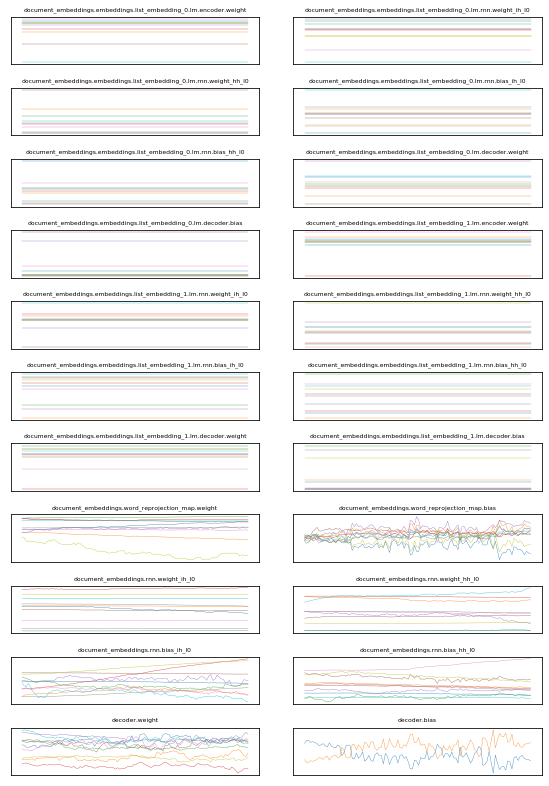

In [14]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('resources/classify/imbd/weights.txt')

In [0]:
classifier = TextClassifier.load('resources/classify/imbd/final-model.pt')

# create example sentence
sentence = Sentence('France is the current world cup winner.')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

In [0]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('Flair is pretty neat!')
classifier.predict(sentence)
# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)